# TP 2:  Computational Graph



During last TP we asked you to make the backward pass, implementing all the derivatives needed. 
As you can expect, doing this every time you make a new model is a little redundant. 
The ML libraries allow you to implement models by focusing only on the forward pass, they construct than a graph and compute derivatives from the bottom to the leafs of the graph. This graph is known as "computational graph".

The aim of this TP is to build a computational graph inspired by [pytorch](https://pytorch.org/), and than test it with a simple model (MLP).
The construction of the model, of the loss and the optimizer are also inspired by pytorch.

The transition to pytorch should be easy in the future.

**Disclaimer** This code is inspired by how users use Pytorch, it doesn't replace Pytorch and the implemtatin differ form Pytorch. The only goal of this TP is to give an intuition how pytorch and the computational graph work, before starting using it!

## The Computational Graph

The computational graph is a graph that specifies the operations done to get a given value. 
If C = A + B, the graph will look like:
```
A
 \
  \
   + -- C 
  /
 /
B
```
or if F = C * D and E = log(F), the graph will look like:
```
A
 \
  \
   + -- C
  /      \
 /        \
B          * -- F -- log -- E
          /
         /
        D
```

As you can see, the graph is build during the "forward pass" and it is easy to see the gradients flow (start on E and end on the leafs A, B and D. 

### Variable
To build this graph in our code, we introduce an object called Variable. This object will look like an array in numpy, it will content data, and have methods like mean, sum, t, etc. Variable has also a grad, a grad__fn, and children field.

* Variable.grad: store the gradients during the backward pass for the given variable (same shape as Variabale.shape)
* Variable.grad_fn: store the function that has built this Variable (addition, multiplication, etc)
* Variable.children: list of all the operations where the Variable was used. We need Variable.children during backward pass to know if all the children have propagate thier gradients before the current variable compute in turn its gradients.

### Functions

Functions cointains all the oprations we can use in your code. Each operation needs a forward and a backward method.
The forward method is simply the __init__ method where you compute and store the result of the operation. 
There is 2 backward methods:
* backward (general): Inherited from the _Function parent class, it calls the second _backward method (see below) and updates the gradients of the variables used to build the current one.
* _backward (specific): Is specific to each operation, computes the gradients for its parents. The derivatives are computed according to the specific operation.

### Functional

Is simply an interface for all functions defined in functions.
You don't need to touch this file. but take a look at it, because it gives you all the functions you have add.
If you don't use a function from this interface, you will not be able to construct the graph and ptopagate trough it.

*|!\* Even the standart operation you can use directly: +, -, *, / use the operation of functional! Take a look at Variable.__add__, Variable.__sub__, Variable.__mul__, Variable.__truediv__ if you doubt.


## What we ask you to do:

Complete the *Fill here* in the following cells of this notebook.
Use latex notation to add your formulas. 
Once you have filled the missing parts of an operation, go to function.py and implement the missing parts of it. Tests are provided by saving the gradients using pytorch on the same conditions (same arrays, gradients cleared between operations).


Before starting with the derivatives, let's take a look at variable.py.
The majority of this class is provided to you. We **ask you to describe a little bit this class in your report, 
mostly the methods backward and update_grad**. Than fill in the missing parts in this two methods.

We will now create the Variables you will use to test your implementation.

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from functional import F
from variable import Variable

def display_variable_information(name, var):
    print("\nName:", name)
    print("Data:\n", var.data)
    print("Shape:", var.shape)
    print("Grad:\n", var.grad)
    print("Grad_fn:", var.grad_fn)

# scalars
a = Variable([4.5])
b = Variable([6.78])

# arrays
C = Variable([[1.73, 2.83], [5.13, 8.43], [5.13, 8.43]])
D = Variable([[3.57, 4.96], [2.06, 1.94], [5.13, 8.43]])


print("Variables Informations:")
# uncomment if you want
display_variable_information("a", a)
#display_variable_information("b", b)
#display_variable_information("c", C)
#display_variable_information("d", D)

Variables Informations:

Name: a
Data:
 [[4.5]]
Shape: (1, 1)
Grad:
 None
Grad_fn: None


In [2]:
from check_values import check_result_and_grads

def clear_variables(*argv):
    """Clear all Variables passed in arguments."""
    for var in argv:
        var.grad = None
        var.grad_fn = None
        var.children = []
        var.retained_values = {}

# Addition

**Given to you as example** 

**Inputs**: $x, y$

**Operation**: $f(x,y) = x + y$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = 1$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot 1 = \frac{\partial}{\partial f}$

+ **w.r.t.** $y$:

    $\frac{\partial f}{\partial y} = 1$
    
    By chain rule:
    $\frac{\partial}{\partial y} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial y} = \frac{\partial}{\partial f} \cdot 1 = \frac{\partial}{\partial f}$

In [3]:
clear_variables(a, b, C, D)

res_scalar = a + b
res_scalar.backward()
check_result_and_grads(res_scalar, a, b, operation="addition", itype="scalar")

res_array = C + D
res_array.mean().backward()
check_result_and_grads(res_array, C, D, operation="addition", itype="array")


Check operation addition(a, b):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK
	Gradients of b:
		Shape: OK
		Content: OK

Check operation addition(C, D):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK
	Gradients of D:
		Shape: OK
		Content: OK


# Subtraction

**Inputs**: $x, y$

**Operation**: $f(x,y) = x - y$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = 1$ 
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot 1 $

+ **w.r.t.** $y$:

    $\frac{\partial f}{\partial y} = -1$
    
    By chain rule:
    $\frac{\partial}{\partial y} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial y} = \frac{\partial}{\partial f} \cdot -1$

In [4]:
clear_variables(a, b, C, D)

res_scalar = a - b
res_scalar.backward()
check_result_and_grads(res_scalar, a, b, operation="subtraction", itype="scalar")

res_array = C - D
res_array.mean().backward()
check_result_and_grads(res_array, C, D, operation="subtraction", itype="array")


Check operation subtraction(a, b):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK
	Gradients of b:
		Shape: OK
		Content: OK

Check operation subtraction(C, D):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK
	Gradients of D:
		Shape: OK
		Content: OK


# Multiplication

**Inputs**: $x, y$

**Operation**: $f(x,y) = x * y$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = y$ 
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot y$

+ **w.r.t.** $y$:

    $\frac{\partial f}{\partial y} =x$
    
    By chain rule:
    $\frac{\partial}{\partial y} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial y} = \frac{\partial}{ \partial f} \cdot x$

In [5]:
clear_variables(a, b, C, D)

res_scalar = a * b
res_scalar.backward()
check_result_and_grads(res_scalar, a, b, operation="multiplication", itype="scalar")

res_array = C * D
res_array.mean().backward()
check_result_and_grads(res_array, C, D, operation="multiplication", itype="array")


Check operation multiplication(a, b):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK
	Gradients of b:
		Shape: OK
		Content: OK

Check operation multiplication(C, D):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK
	Gradients of D:
		Shape: OK
		Content: OK


# Division

**Inputs**: $x, y$

**Operation**: $f(x,y) = x / y$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = 1 / y$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{1}{y}$

+ **w.r.t.** $y$:

    $\frac{\partial f}{\partial y} = -\frac{x}{y^2}$
    
    By chain rule:
    $\frac{\partial}{\partial y} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial y} = \frac{\partial}{\partial f} \cdot -\frac{x}{y^2}$ 

In [6]:
clear_variables(a, b, C, D)

res_scalar = a / b
res_scalar.backward()
check_result_and_grads(res_scalar, a, b, operation="division", itype="scalar")

res_array = C / D
res_array.mean().backward()
check_result_and_grads(res_array, C, D, operation="division", itype="array")


Check operation division(a, b):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK
	Gradients of b:
		Shape: OK
		Content: OK

Check operation division(C, D):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK
	Gradients of D:
		Shape: OK
		Content: OK


# Matrix Multiplication

**Inputs**: $x, y$

**Operation**: $f(x,y) = x.dot(y)$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = y$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f}.dot(y^T)$

+ **w.r.t.** $y$:

    $\frac{\partial f}{\partial y} = x$
    
    By chain rule:
    $\frac{\partial}{\partial y} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial y} = x^T.dot(\frac{\partial}{\partial f})$ 

In [7]:
clear_variables(a, b, C, D)

res_array = F.matmul(C.t(), D)
res_array.mean().backward()

check_result_and_grads(res_array, C, D, operation="matMul", itype="array")


Check operation matMul(C, D):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK
	Gradients of D:
		Shape: OK
		Content: OK


# Exponential

**Inputs**: $x$

**Operation**: $f(x) = e^x$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = e^x$ 
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot e^x$

In [8]:
clear_variables(a, b, C, D)

res_scalar = F.exp(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="exp", itype="scalar")

res_array = F.exp(C)
res_array.mean().backward()
check_result_and_grads(res_array, C, operation="exp", itype="array")


Check operation exp(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation exp(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Natural Logarithm

**Inputs**: $x$

**Operation**: $f(x) = ln(x)$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = \frac{1}{ln(x)}$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{1}{ln(x)}$

In [9]:
clear_variables(a, b, C, D)

res_scalar = F.log(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="log", itype="scalar")

res_array = F.log(C)
res_array.mean().backward()
check_result_and_grads(res_array, C, operation="log", itype="array")


Check operation log(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation log(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Sinus

**Inputs**: $x$

**Operation**: $f(x) = \sin(x)$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = cos(x)$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot cos(x)$

In [10]:
clear_variables(a, b, C, D)

res_scalar = F.sin(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="sin", itype="scalar")

res_array = F.sin(C)
res_array.mean().backward()
check_result_and_grads(res_array, C, operation="sin", itype="array")


Check operation sin(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation sin(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Cosinus

**Inputs**: $x$

**Operation**: $f(x) = \cos(x)$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = -sin(x)$ 
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot -sin(x)$

In [11]:
clear_variables(a, b, C, D)

res_scalar = F.cos(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="cos", itype="scalar")

res_array = F.cos(C)
res_array.mean().backward()
check_result_and_grads(res_array, C, operation="cos", itype="array")


Check operation cos(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation cos(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Tangent

**Inputs**: $x$

**Operation**: $f(x) = \tan(x)$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = \frac{1}{cos(x)^2}$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{1}{cos(x)^2}$

In [12]:
clear_variables(a, b, C, D)

res_scalar = F.tan(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="tan", itype="scalar")

res_array = F.tan(C)
res_array.mean().backward()
check_result_and_grads(res_array, C, operation="tan", itype="array")


Check operation tan(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation tan(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Sigmoid

**Inputs**: $x$

**Operation**: $f(x) = \frac{1}{1 + e^{-x}}$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = (\frac{1}{1 + e^{-x}})(1 - \frac{1}{1 + e^{-x}})$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot (\frac{1}{1 + e^{-x}})(1 - \frac{1}{1 + e^{-x}})$

In [13]:
clear_variables(a, b, C, D)

res_scalar = F.sigmoid(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="sigmoid", itype="scalar")

res_array = F.sigmoid(C)
res_array[0,0].backward()
check_result_and_grads(res_array, C, operation="sigmoid", itype="array")


Check operation sigmoid(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation sigmoid(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Tanh

**Inputs**: $x$

**Operation**: $f(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} =  (1 - \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}})^2$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot (1 - \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}})^2 $

In [14]:
clear_variables(a, b, C, D)

res_scalar = F.tanh(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="tanh", itype="scalar")

res_array = F.tanh(C)
res_array[0,0].backward()
check_result_and_grads(res_array, C, operation="tanh", itype="array")


Check operation tanh(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation tanh(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# ReLu

**Inputs**: $x$

**Operation**: $f(x) = \max(0, x)$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = $ if x < 0 then 0 else 1
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot $ if x < 0 then 0 else 1

In [15]:
clear_variables(a, b, C, D)

res_scalar = F.relu(a)
res_scalar.backward()
check_result_and_grads(res_scalar, a, operation="relu", itype="scalar")

res_array = F.relu(C)
res_array[0,0].backward()
check_result_and_grads(res_array, C, operation="relu", itype="array")


Check operation relu(a):
	Result:
		Shape: OK
		Content: OK
	Gradients of a:
		Shape: OK
		Content: OK

Check operation relu(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Softmax

***The derivative of the softmax is not trivial to computein a vectorized manner, I have done the exercice and give you my implementation of the softmax, feel free to ask me questions about it.***

***You have to fill bellow the formulas!***

**Inputs**: $x$

**Operation**: $f(x) = \frac{e^{x_i}}{\sum_i e^{x_i}}$

**Derivatives**:
+ **w.r.t.** $x$: 
    
    $\frac{\partial f}{\partial x} = f(x_j)(I[i == j] - f(x_i)$
    
    By chain rule:
    $\frac{\partial}{\partial x} = \frac{\partial}{\partial f} \cdot \frac{\partial f}{\partial x} = \frac{\partial}{\partial f} \cdot f(x_j)(I[i == j] - f(x_i)$

In [16]:
clear_variables(a, b, C, D)

res_array = F.softmax(C, dim=0)
res_array[0,0].backward()

check_result_and_grads(res_array, C, operation="softmax", itype="array")


Check operation softmax(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


# Cross Entropy Loss

For the Cross entropy loss we have used  the trick from pytorch that implements direclty the cross entropy loss with the softmax for more stability.

Take a look [here](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

You don't have to implement it but make sure you understand what append here, comment it on your report.


In [17]:
import nn as nn

X = Variable([[0.1711, 0.5140, 0.3149], [0.1359, 0.4985, 0.3656], [0.0275, 0.5467, 0.4258]])
y = Variable([1, 2, 0])

cel = nn.CrossEntropyLoss()

loss = cel(X, y)

loss.backward()

check_result_and_grads(res_array, X, operation="CEL", itype="array")


Check operation CEL(C):
	Result:
		Shape: OK
		Content: OK
	Gradients of C:
		Shape: OK
		Content: OK


## An MLP as example

Now that you have all the components filled for the graph computational, you will need some additional steps to make a MLP trainable.

You have to complete the missing parts in ***nn.py*** and in ***optim.py***.


First we will generate a simple dataset, each color represents each class.
As you can see, we have 3 classes and each sample has 2 features (the cordinates).

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


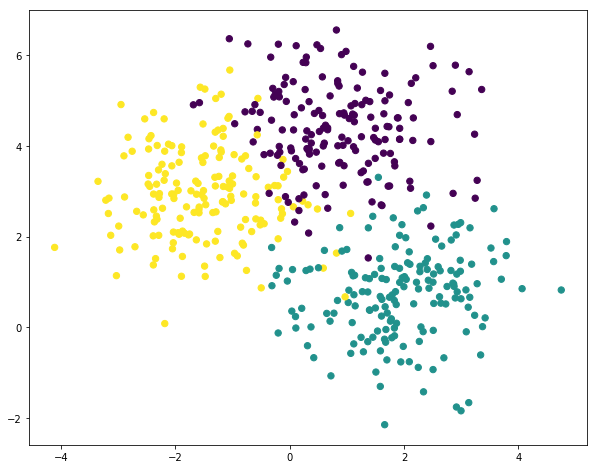

In [18]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.linear_model

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generate a dataset and plot it# Gener
N = 500
np.random.seed(0)
X, y = sklearn.datasets.make_blobs(N)
plt.scatter(X[:,0], X[:,1], s=40, c=y)

X_train = X[:350]
y_train = y[:350]
X_test = X[350:]
y_test = y[350:]

## Define and train the MLP

Follow the todos here and complete the missing parts in ***nn.py*** and ***optim.py***.

List of things you have to do. You can put a 'x' inside the [ ] when you have done it!
Example: * [x] Example done.



* nn.py:
    * Linear:
        * in init
            * [x] Initialize the weights.
            * [x] Initialize the bias.
        * in call:
            * [x] Implement the linear transformation.
            * [x] Add the bias.
* optim.py:
    * SGD:
        * in step:
            * [x] Implement the SGD update mechanism.

In [19]:
from functional import F
from variable import Variable
import nn as nn
from optim import SGD

np.random.seed(13)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        #######################################################################
        # TODO: define 2 linear layers, one that takes the inputs and outputs
        # values with hidden_size
        # and the second one that takes the values from the first layer and
        # outputs the scores. 
        # implement Linear in nn.py before, you need it here.
        #######################################################################
        self.first = nn.Linear(in_features, hidden_size)
        self.second = nn.Linear(hidden_size, out_features)
        #######################################################################
        # --------------------------- END OF YOUR CODE ------------------------
        #######################################################################

        
    def forward(self, X):
        output = None
        #######################################################################
        # TODO: define your forward pass as follow
        #    1) y = linear(inputs)
        #    2) y_nl = relu(y)
        #    3) output = linear(y_nl)
        # softmax not needed because it's already in cross entropy
        #######################################################################
        y = self.first(X)
        y_nl = F.relu(y)
        output = self.second(y_nl)
        #######################################################################
        # --------------------------- END OF YOUR CODE ------------------------
        #######################################################################
        return output


model = MLP(2, 100, 3)

optimizer = SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 1000
batch_size = 50

history_losses = []
history_acc = []

for epoch in range(1, epochs+1):
    model.train()
    
    indices = range(X_train.shape[0])

    train_losses = []
    train_acc = []
    
    for iteration in range(X_train.shape[0]//batch_size):
        batch_indices = np.random.choice(indices, batch_size)
        indices = list(set(indices) - set(batch_indices))

        X_batch = Variable(X_train[batch_indices])
        y_batch = Variable(y_train[batch_indices])
        
        
        #######################################################################
        # TODO: Add here all the elements you need to train your model for each
        # batch.
        #######################################################################
        
        # you need to clear out the gradients for all the parameters
        model.parameters().zero_grad()
        
        # compute the forward pass
        outputs = model.forward(X_batch)
        
        # compute tht loss
        loss = loss_fn(outputs, y_batch)
        
        # compute the backward pass
        loss.backward()
        
        # optimize
        
        optimizer.step()
        #######################################################################
        # --------------------------- END OF YOUR CODE ------------------------
        #######################################################################

        # keep loss
        train_losses.append(loss.item())
        
        # keep accuracy
        y_pred = np.argmax(outputs.data, axis=1)
        train_acc.append((y_pred[:, None] == y_batch.data).mean())
    
    history_losses.append(np.mean(train_losses))
    history_acc.append(np.mean(train_acc))
    
    # mod allow us to only display in a logaritmic way
    mod = 10**np.floor(np.log10(epoch))
    if epoch % mod == 0:
        print("Epoch {:>3}/{:>3}, loss {:.4f}, acc {:.2f}".format(epoch, epochs, history_losses[-1], history_acc[-1]))

Epoch   1/1000, loss 1.4016, acc 0.33
Epoch   2/1000, loss 1.2663, acc 0.35
Epoch   3/1000, loss 1.1793, acc 0.31
Epoch   4/1000, loss 1.0819, acc 0.43
Epoch   5/1000, loss 1.0081, acc 0.57
Epoch   6/1000, loss 0.9527, acc 0.62
Epoch   7/1000, loss 0.9147, acc 0.73
Epoch   8/1000, loss 0.8884, acc 0.79
Epoch   9/1000, loss 0.8496, acc 0.79
Epoch  10/1000, loss 0.8239, acc 0.79
Epoch  20/1000, loss 0.6488, acc 0.85
Epoch  30/1000, loss 0.5563, acc 0.89
Epoch  40/1000, loss 0.4949, acc 0.89
Epoch  50/1000, loss 0.4495, acc 0.90
Epoch  60/1000, loss 0.4069, acc 0.91
Epoch  70/1000, loss 0.4050, acc 0.90
Epoch  80/1000, loss 0.3761, acc 0.90
Epoch  90/1000, loss 0.3622, acc 0.91
Epoch 100/1000, loss 0.3433, acc 0.91
Epoch 200/1000, loss 0.2666, acc 0.91
Epoch 300/1000, loss 0.2382, acc 0.92
Epoch 400/1000, loss 0.2223, acc 0.92
Epoch 500/1000, loss 0.2060, acc 0.93
Epoch 600/1000, loss 0.2142, acc 0.92
Epoch 700/1000, loss 0.2151, acc 0.92
Epoch 800/1000, loss 0.1686, acc 0.94
Epoch 900/10

## Visualisation

Now you can visualise for fun the loss and the accuracy of your model during trainning and get the final accuracy.

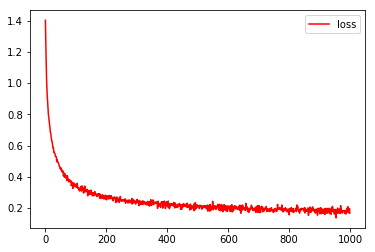

In [20]:
plt.plot(history_losses, c="r", label="loss")
plt.legend()
plt.show()

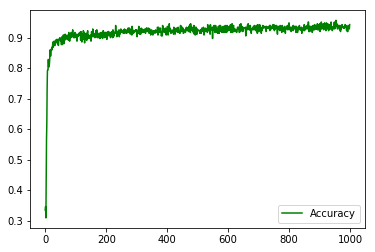

In [21]:
plt.plot(history_acc, c="g", label="Accuracy")
plt.legend()
plt.show()

You should get ~90% of accuracy with the test set.

In [22]:
model.eval()
X_test_var = Variable(X_test)

outputs = model(X_test_var)

y_pred = np.argmax(outputs.data, axis=1)
acc = (y_pred == y_test).mean()

print("Accuracy on test set: {:.2f}".format(acc))

Accuracy on test set: 0.91
